In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import latexify
from graphviz import Digraph

In [1]:
!nvidia-smi

Thu Oct 13 22:46:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    N/A /  N/A |      4MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
@latexify.with_latex
def f(x):
    return 3*x**2 -4*x +5
f

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x7effa7aa4f50>

In [3]:
#@latexify.with_latex
f(2.0)

9.0

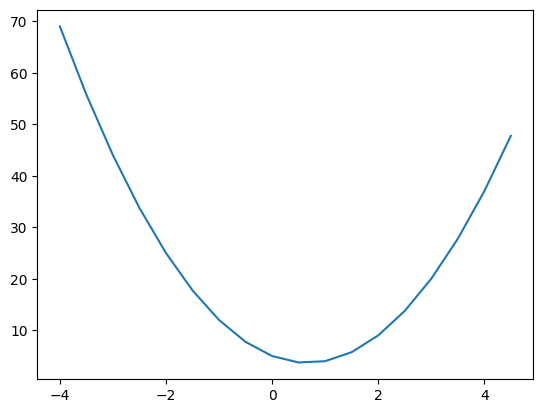

In [4]:
xp=np.arange(-4,5,0.5)
yp=f(xp)
plt.plot(xp,yp)

In [5]:
#let have some intution about the expression derivative
#inputs 
h=0.001
a=1
b=-6
c=10
d=a*b-c
print((f(a+h)-f(a))/h)
print(d)


2.002999999999311
-16


In [6]:
h=0.001
d1=a*b-c
c+=h
d2=a*b-c
print("d1",d1)
print("d2",d2)
print("slop",(d1-d2)/h)

d1 -16
d2 -16.000999999999998
slop 0.9999999999976694


### section 2 build the data struct to handle input of values function 
1. here we will create a class object Value that repesent the data structure of some operations 
2. after we will need to create a graph to show to trace the tyep OP and data's value 

* that will help us to understand Backware-forwared algorithm 

In [7]:
class Value:
    def __init__(self,data,_child={},_op='',label='',grad=0.0):
        self.data=data
        self._prev=set(_child)
        self._op=_op
        self._backward= lambda :None 
        self.grad=0.0
        self.label=label
        
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data + other.data,(self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
            
            
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
  
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1
  
    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

        
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,{self,},'tanh')
        
        def _backward():
             self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
             self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
    
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a=Value(2.3,label='a')
b=Value(0.3,label='b')
c =Value(0.6,label='c')
e=a*c;e.label='e'
d=e+b;d.label='d'
f=Value(2.0,label='f')
L=d*f;L.label='output'

L._prev


{value(data=1.68), value(data=2.0)}

In [8]:
class foo(object):
    
    def __init__(self, val):
        self.val = val 
    
    def __str__(self):

        return f"value : {self.val}"
    def __rmul__(self,other):
        return self.val * other.val
              
class bar(object):
        def __init__(self, val):
             self.val = val 
        def __str__(self):
            
             f"value{self.val}"
                
        def __rmul__(self,other):
            return self.val * other.val
n=foo(4)
k=bar(2)
print(n * k )

8


In [9]:
l=[2,3,5,6,9,4]
l.sort(reverse=True)
l

[9, 6, 5, 4, 3, 2]

In [10]:
#d._prev
d._op

'+'

In [196]:
#let us first build the graph (nodes and edges) to store them 
# in pathaway 
import pylab
def trace(root):
    nodes , edges= set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for chlid in v._prev:
                edges.add((chlid,v))
                build(chlid)
    build(root)
    return nodes,edges
# filename = g1.render(filename = 'img/g1')

# pylab.savefig('filename.png')
def draw_dot(root,graph_name):
    dot=Digraph(format="png",graph_attr={'rankdir':"RL"})
   


    
    nodes,edges=trace(root)
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        uid=str(id(n))
        dot.node(name=uid,label="%s | data %.4f | grad %.4f"  % (n.label,n.data,n.grad),shape="record")
        if n._op:
            dot.node(name=uid + n._op,label=n._op)
            dot.edge(uid+n._op,uid)
    for n1 , n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
        
        #pylab.savefig()
        
    out_dirview='img'
    dot.render(graph_name, directory=out_dirview,view=True)
            
    return dot        
                 
    
           

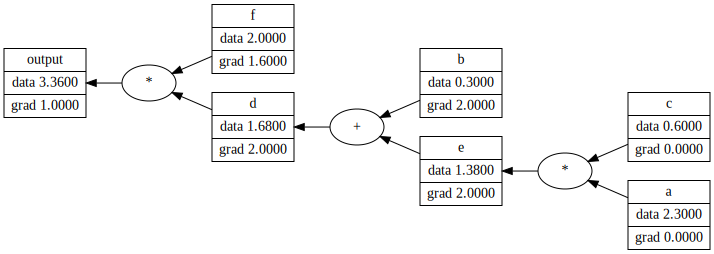


(eog:7626): Gtk-WARNING **: 23:49:48.000: Theme file for Vimix-cursors has no directories


In [182]:
import os
os.environ["PATH"] += os.pathsep + '/home/yunus/mirco/algo/lib/python3.7/site-packages/graphviz'
draw_dot(L,'graph_single_node')

* To insert a mathematical formula of Derivative function ay point to calculte the Grad of rate change
 as follows:

Derivative function:

$$ f'(x) = \lim\limits_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h}   $$



In [13]:
f.grad=1.6
d.grad=2
e.grad=2
b.grad=2
L.grad= 1.0

##### Chaine rule 
the chain rule is a formula that expresses the derivative of the composition of two differentiable functions f and g in terms of the derivatives of f and g. More precisely, if

$$ h = f ∘ g {\displaystyle h=f\circ g} {\displaystyle h=f\circ g} $$
is the function such that 

$$$$$$ h ( x ) =  ( g ( x ) ) {\displaystyle h(x)=f(g(x))} {\displaystyle h(x)=f(g(x))} $$$$$$

for every x, then the chain rule is, in Lagrange's notation, 

The chain rule may also be expressed in Leibniz's notation. If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as

  $$ {\displaystyle {\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}},} {\displaystyle {\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}},} $$

and

  $$ {\displaystyle \left.{\frac {dz}{dx}}\right|_{x}=\left.{\frac {dz}{dy}}\right|_{y(x)}\cdot \left.{\frac {dy}{dx}}\right|_{x},} {\displaystyle \left.{\frac {dz}{dx}}\right|_{x}=\left.{\frac {dz}{dy}}\right|_{y(x)}\cdot \left.{\frac {dy}{dx}}\right|_{x},} $$

In [14]:
def chaine_role():
    h=0.01
    a=Value(2.3,label='a')
    b=Value(0.3,label='b')
    c =Value(0.6,label='c')
    e=a*c;e.label='e'
    d=e+b;d.label='d'
    f=Value(2.0,label='f')
    L=d*f;L.label='output'
    L1=L.data
    
    a=Value(2.3,label='a')
    b=Value(0.3,label='b')
    b.data+=h
    c =Value(0.6,label='c')
    e=a*c;e.label='e'
    #e.data+=h
    d=e+b;d.label='d'
    f=Value(2.0,label='f')
    L=d*f;L.label='output'
    L2=L.data
    print((L2-L1)/h)
chaine_role()   

2.0000000000000018


#### Section nuilding basic Neural network function 
1. NN is just simple formula functio that combine between Weights and bias repesectively to input data 
2. NN is complec biology stucture but we have simplify function body 
![neural_network](<img src="neural_networks-009.png " width="500" height="500">)
$$ F(x) = \alpha (\sum_{i}^{j}(w_{i}x^{(0)}_{i}+b_{j}^{(0)})$$

##### the activation function that  map the output of funcition to probability distobutions Tanh 
* and there's some few function actication can be used based on the case 
$$ Tanh(x)= \frac{e^{2x} -1}{ e^{2x} -1 } $$


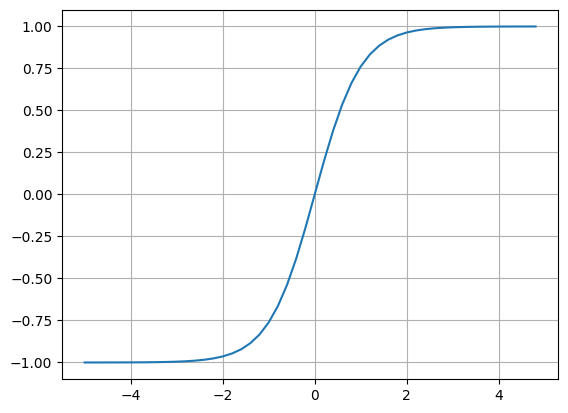

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [187]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [188]:
o.backward()

In [185]:
#n.backward()

In [186]:
#b.backward()

In [20]:
# x2w2.backward()
# x1w1.backward()

In [21]:
#x1w1x2w2.backward()

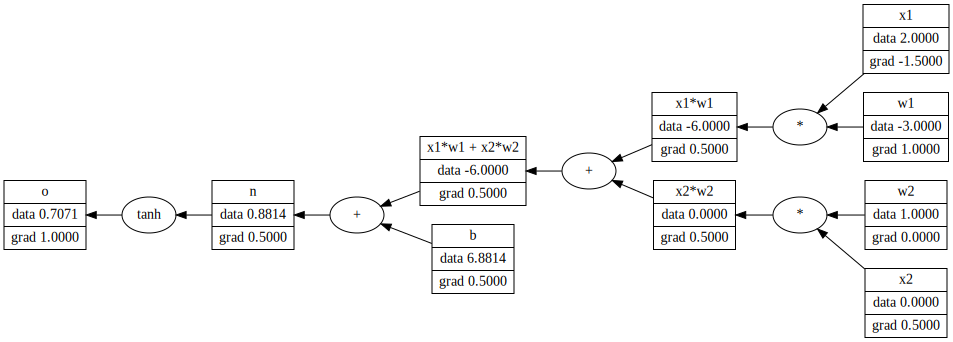


(eog:7754): Gtk-WARNING **: 23:50:57.871: Theme file for Vimix-cursors has no directories


In [189]:
draw_dot(o,'graph_backward')

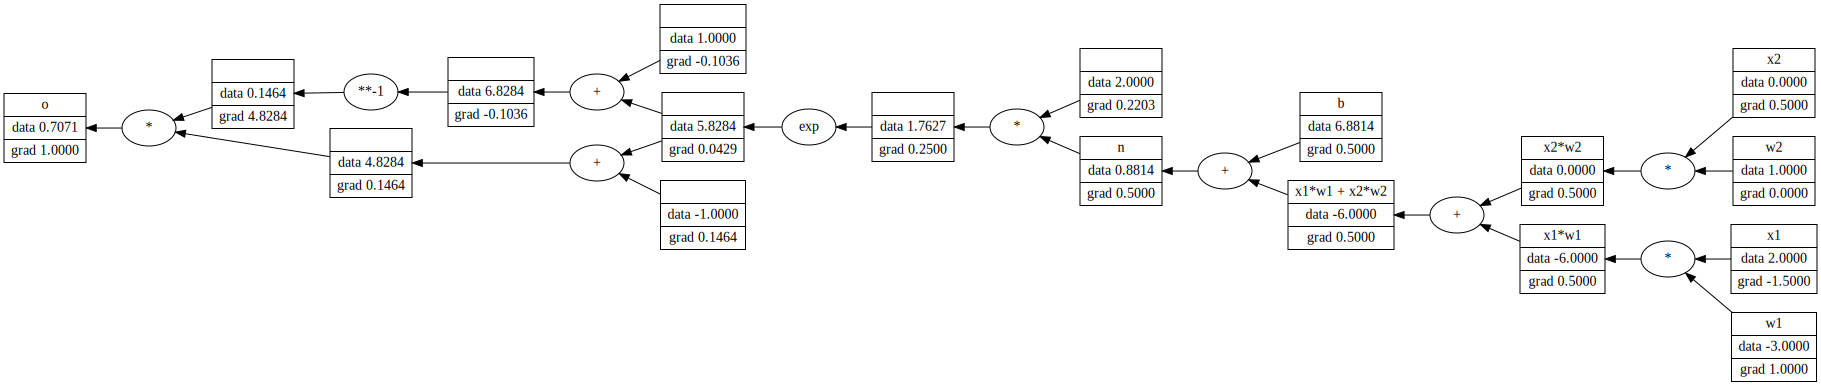


(eog:7897): Gtk-WARNING **: 23:51:41.886: Theme file for Vimix-cursors has no directories


In [191]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o,'Graph_simulare_Neural_network_backPro')

In [25]:
def topological_sort(graph):
    visited = set()
    stack = []
    for node in graph:
        if node not in visited:
            topological_helper(graph, node, visited, stack)
    return stack[::-1]


        
def topological_helper(graph, node, visited, stack):
    visited.add(node)
    for neighbour in graph[node]:
        if neighbour not in visited:
            topological_helper(graph, neighbour, visited, stack)
    stack.append(node)


if __name__ == '__main__':
    graph = {
        'physics': ['signal_processing'],
        'calculus': ['physics'],
        'linear_algebra': ['signal_processing'],
        'signal_processing': ['photonics'],
        'photonics': [],
        'physic': ['signal_processing']
        }
    print(topological_sort(graph))
    

['physic', 'linear_algebra', 'calculus', 'physics', 'signal_processing', 'photonics']


In [37]:
# arr=[1,2,3]
# l= [1,2,4]
# mul=zip(arr,l)
# for i,(x,y) in enumerate(zip(arr,l)):
#      print(f"{i}:",x * y )

0: 1
1: 4
2: 12


In [197]:
class Neuron:
    #here we will build the neural net expression by usig V
    def __init__(self,nin):
        self.w = [Value(np.random.uniform(1,-1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(1,-1))
    
    def __call__(self,x):
        #print(list(zip(self.w,x)))
        #lets us combine the linear function ( w*x + b )
        act =sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out =act.tanh()
        return out
    
class Layer:
    
    def __init__(self,nin,outs):
        self.neurons=[Neuron(nin) for _ in range(outs)]
       
        
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    
x=[1,3,4]
n=MLP(3,[4,4,1])
n(x)


value(data=0.9473757736828202)

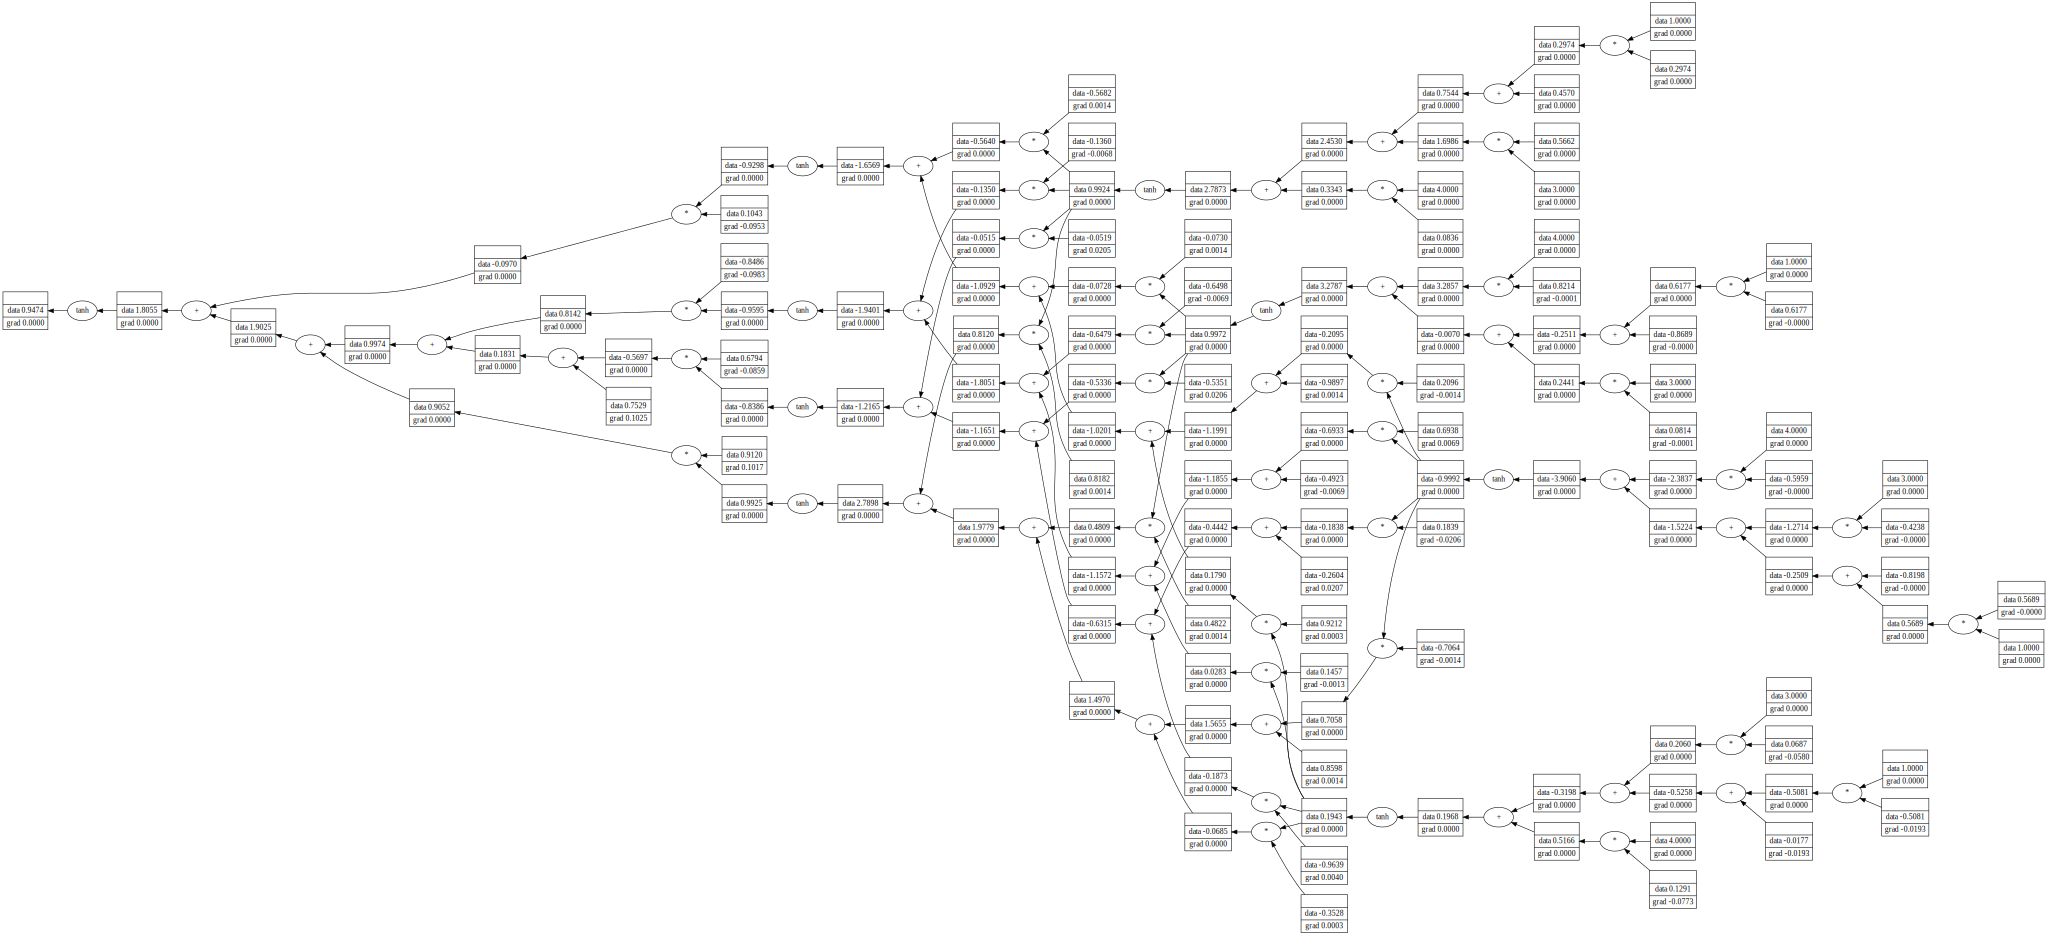

In [199]:
n(x).backward()
draw_dot(n(x),'Graph_MLP_nurona')